In [182]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)

from sqlalchemy import create_engine
import urllib

server = r'DESKTOP-1IV1IS2\SQLEXPRESS'
database = 'DataWarehouse'

params = urllib.parse.quote_plus(
    f"DRIVER=ODBC Driver 17 for SQL Server;"
    f"SERVER={server};"
    f"DATABASE={database};"
    "Trusted_Connection=yes;"
)

engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

connection = engine.connect()

df = pd.read_sql("SELECT * FROM gold.report_customers", connection)
df.head()

,customer_key,customer_number,customer_name,age,age_group,customer_segment,last_order_date,recency,total_orders,total_sales,total_quantity,lifespan,avg_order_value,avg_monthly_spend
0,1,AW00011000,Jon Yang,55.0,above 50,VIP,2013-05-03,152,3,8249,8,28,2749,294
1,2,AW00011001,Eugene Huang,50.0,above 50,VIP,2013-12-10,145,3,6384,11,35,2128,182
2,3,AW00011002,Ruben Torres,55.0,above 50,VIP,2013-02-23,155,3,8114,4,25,2704,324
3,4,AW00011003,Christy Zhu,53.0,above 50,VIP,2013-05-10,152,3,8139,9,29,2713,280
4,5,AW00011004,Elizabeth Johnson,47.0,40-49,VIP,2013-05-01,152,3,8196,6,28,2732,292


In [183]:
df.shape

(18482, 14)

In [184]:
df.describe()

,customer_key,age,recency,total_orders,total_sales,total_quantity,lifespan,avg_order_value,avg_monthly_spend
count,18482.000000,18465.000000,18482.000000,18482.000000,18482.000000,18482.000000,18482.000000,18482.000000,18482.000000
mean,9242.344281,57.177471,149.793962,1.496429,1588.099665,3.268261,5.169841,911.652364,452.775133
std,5335.992085,11.535341,4.796985,1.101186,2123.778423,2.631571,8.513890,1040.614162,738.903025
min,1.000000,40.000000,144.000000,1.000000,2.000000,1.000000,0.000000,2.000000,1.000000
25%,4621.250000,48.000000,146.000000,1.000000,50.000000,2.000000,0.000000,40.000000,39.000000
50%,9242.500000,55.000000,149.000000,1.000000,272.000000,3.000000,0.000000,157.000000,122.000000
75%,13862.750000,65.000000,152.000000,2.000000,2511.000000,4.000000,9.000000,1770.000000,471.000000
max,18484.000000,110.000000,181.000000,28.000000,13294.000000,68.000000,36.000000,3578.000000,4219.000000


In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18482 entries, 0 to 18481
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_key       18482 non-null  int64  
 1   customer_number    18482 non-null  object 
 2   customer_name      18482 non-null  object 
 3   age                18465 non-null  float64
 4   age_group          18482 non-null  object 
 5   customer_segment   18482 non-null  object 
 6   last_order_date    18482 non-null  object 
 7   recency            18482 non-null  int64  
 8   total_orders       18482 non-null  int64  
 9   total_sales        18482 non-null  int64  
 10  total_quantity     18482 non-null  int64  
 11  lifespan           18482 non-null  int64  
 12  avg_order_value    18482 non-null  int64  
 13  avg_monthly_spend  18482 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 2.0+ MB


In [186]:
df['last_order_date'] = pd.to_datetime(df['last_order_date'], errors= 'coerce')
df['age'] = df['age'].astype('Int64')
df.dtypes

customer_key                  int64
customer_number              object
customer_name                object
age                           Int64
age_group                    object
customer_segment             object
last_order_date      datetime64[ns]
recency                       int64
total_orders                  int64
total_sales                   int64
total_quantity                int64
lifespan                      int64
avg_order_value               int64
avg_monthly_spend             int64
dtype: object

-----------------------------------------------------------------------------------------------------------------------------------

# Recency Frequency Monetary (RFM) Analysis

A powerful framework for understanding customer value by analyzing *R*ecency (how recently they bought), *F*requency (how often they purchase), and *M*onetary (how much they spend). This segmentation enables targeted marketing, improved retention, and personalized customer engagement strategies.

In [187]:
rfm = df[['customer_key', 'recency', 'total_orders', 'total_sales']].copy()

rfm.columns = ['customer_key', 'Recency', 'Frequency', 'Monetary']

In [188]:
rfm.head()

,customer_key,Recency,Frequency,Monetary
0,1,152,3,8249
1,2,145,3,6384
2,3,155,3,8114
3,4,152,3,8139
4,5,152,3,8196


In [189]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])

# Business-meaningful frequency bins
F_edges = [0, 1, 2, 5, 10, rfm['Frequency'].max()]
rfm['F_score'] = pd.cut(rfm['Frequency'], bins=F_edges, labels=[1, 2, 3, 4, 5], include_lowest=True)

rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

In [190]:
rfm

,customer_key,Recency,Frequency,Monetary,R_score,F_score,M_score
0,1,152,3,8249,2,3,5
1,2,145,3,6384,5,3,5
2,3,155,3,8114,1,3,5
3,4,152,3,8139,2,3,5
4,5,152,3,8196,2,3,5
...,...,...,...,...,...,...,...
18477,18480,160,1,2049,1,1,4
18478,18481,150,1,2442,3,1,4
18479,18482,173,1,3375,1,1,5
18480,18483,160,1,2049,1,1,4


In [191]:
# See the actual value ranges behind each rfm score
(rfm.groupby('R_score', observed=False)['Recency'].agg(['min','max','count']),
rfm.groupby('F_score', observed=False)['Frequency'].agg(['min','max','count']),
rfm.groupby('M_score', observed=False)['Monetary'].agg(['min','max','count']))

(         min  max  count
 R_score                 
 5        144  146   4815
 4        147  148   3467
 3        149  150   3058
 2        151  153   4035
 1        154  181   3107,
          min  max  count
 F_score                 
 1          1    1  11617
 2          2    2   5454
 3          3    5   1367
 4          6    7      9
 5         16   28     35,
           min    max  count
 M_score                    
 1           2     40   4169
 2          41     92   3232
 3          93   1155   3709
 4        1158   3271   3676
 5        3273  13294   3696)

In [192]:
rfm = rfm[['customer_key', 'Recency', 'Frequency', 'Monetary',
           'R_score', 'F_score', 'M_score']].copy()

rfm['RFM_Score'] = (
    rfm['R_score'].astype(str) +
    rfm['F_score'].astype(str) +
    rfm['M_score'].astype(str)
)


In [193]:
rfm

,customer_key,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
0,1,152,3,8249,2,3,5,235
1,2,145,3,6384,5,3,5,535
2,3,155,3,8114,1,3,5,135
3,4,152,3,8139,2,3,5,235
4,5,152,3,8196,2,3,5,235
...,...,...,...,...,...,...,...,...
18477,18480,160,1,2049,1,1,4,114
18478,18481,150,1,2442,3,1,4,314
18479,18482,173,1,3375,1,1,5,115
18480,18483,160,1,2049,1,1,4,114


In [194]:
# segment based on rfm scores
def rfm_segment(row):
    
    # Champions:
    # - Very recent buyers (high R)
    # - Buy frequently (high F)
    # - Spend a lot (high M)
    # These customers drive the most value and should be retained and rewarded.
    if row['R_score'] >= 4 and row['F_score'] >= 4 and row['M_score'] >= 4:
        return 'Champions'

    # Loyal Customers:
    # - Recent buyers
    # - Buy relatively often
    # - May not always be the highest spenders
    # These customers are consistent and should be nurtured to become Champions.
    elif row['R_score'] >= 4 and row['F_score'] >= 3:
        return 'Loyal Customers'

    # At Risk (High Value):
    # - Have not purchased recently (low R)
    # - Historically high spenders (high M)
    # These customers are valuable but showing churn signals
    # and should be targeted with re-engagement campaigns.
    elif row['R_score'] <= 2 and row['M_score'] >= 4:
        return 'At Risk (High Value)'

    
    # Churn Risk:
    # - Have not purchased recently
    # - Low purchase frequency
    # These customers show strong churn behavior and may require incentives
    # or could be deprioritized depending on strategy.
    elif row['R_score'] <= 2 and row['F_score'] <= 2:
        return 'Churn Risk'

    # Needs Attention:
    # - All other customers who do not strongly fit the above categories
    # These customers have moderate behavior and require monitoring.
    else:
        return 'Needs Attention'

rfm['engagement_level'] = rfm.apply(rfm_segment, axis=1)


In [195]:
rfm.sample(10)

,customer_key,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,engagement_level
3251,3252,146,1,72,5,1,2,512,Needs Attention
3146,3147,147,3,6750,4,3,5,435,Loyal Customers
3746,3747,148,2,1588,4,2,4,424,Needs Attention
13921,13923,152,2,2145,2,2,4,224,At Risk (High Value)
6198,6200,149,3,6998,3,3,5,335,Needs Attention
6950,6952,150,1,27,3,1,1,311,Needs Attention
8427,8429,156,2,1878,1,2,4,124,At Risk (High Value)
14256,14258,150,1,147,3,1,3,313,Needs Attention
713,714,146,2,192,5,2,3,523,Needs Attention
3454,3455,153,1,32,2,1,1,211,Churn Risk


In [196]:
rfm['engagement_level'].value_counts()


engagement_level
Needs Attention         10394
Churn Risk               4163
At Risk (High Value)     2952
Loyal Customers           955
Champions                  18
Name: count, dtype: int64

In [197]:
df = df.merge(rfm[['customer_key', 'R_score', 'F_score', 'M_score', 'engagement_level']],
              on='customer_key',
              how='left')
df

,customer_key,customer_number,customer_name,age,age_group,customer_segment,last_order_date,recency,total_orders,total_sales,total_quantity,lifespan,avg_order_value,avg_monthly_spend,R_score,F_score,M_score,engagement_level
0,1,AW00011000,Jon Yang,55,above 50,VIP,2013-05-03,152,3,8249,8,28,2749,294,2,3,5,At Risk (High Value)
1,2,AW00011001,Eugene Huang,50,above 50,VIP,2013-12-10,145,3,6384,11,35,2128,182,5,3,5,Loyal Customers
2,3,AW00011002,Ruben Torres,55,above 50,VIP,2013-02-23,155,3,8114,4,25,2704,324,1,3,5,At Risk (High Value)
3,4,AW00011003,Christy Zhu,53,above 50,VIP,2013-05-10,152,3,8139,9,29,2713,280,2,3,5,At Risk (High Value)
4,5,AW00011004,Elizabeth Johnson,47,40-49,VIP,2013-05-01,152,3,8196,6,28,2732,292,2,3,5,At Risk (High Value)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18477,18480,AW00029479,Tommy Tang,57,above 50,New,2012-09-04,160,1,2049,1,0,2049,2049,1,1,4,At Risk (High Value)
18478,18481,AW00029480,Nina Raji,49,40-49,New,2013-07-17,150,1,2442,5,0,2442,2442,3,1,4,Needs Attention
18479,18482,AW00029481,Ivan Suri,61,above 50,New,2011-08-13,173,1,3375,1,0,3375,3375,1,1,5,At Risk (High Value)
18480,18483,AW00029482,Clayton Zhang,62,above 50,New,2012-09-18,160,1,2049,1,0,2049,2049,1,1,4,At Risk (High Value)


-----------------------------------------------------------------------------------------------------------------------------------

# Churn & Retention Analysis

Customer churn was analyzed using behavioral signals derived from RFM segmentation, with **recency** serving as the primary indicator of disengagement. Higher recency values indicate longer periods of inactivity and a greater likelihood of churn.


In [198]:
recency_by_segment = (df.groupby('engagement_level')['recency']
                      .agg(['mean','median','count'])
                      .sort_values('mean'))
recency_by_segment

,mean,median,count
engagement_level,,,
Champions,145.000000,145.0,18
Loyal Customers,145.974869,146.0,955
Needs Attention,147.166538,147.0,10394
Churn Risk,153.121787,153.0,4163
At Risk (High Value),155.616870,153.0,2952


### Chun & Retention Analysis (insight):
By examining average and median recency across engagement level, clear differences in churn risk emerge. *Champions* and *Loyal Customers* exhibit the lowest recency, while *Churn Risk* and *At Risk (High Value)* segments show significantly higher recency, confirming elevated churn risk.

This analysis enables early identification of customers requiring retention or win-back strategies before revenue is lost.

<Figure size 800x600 with 0 Axes>

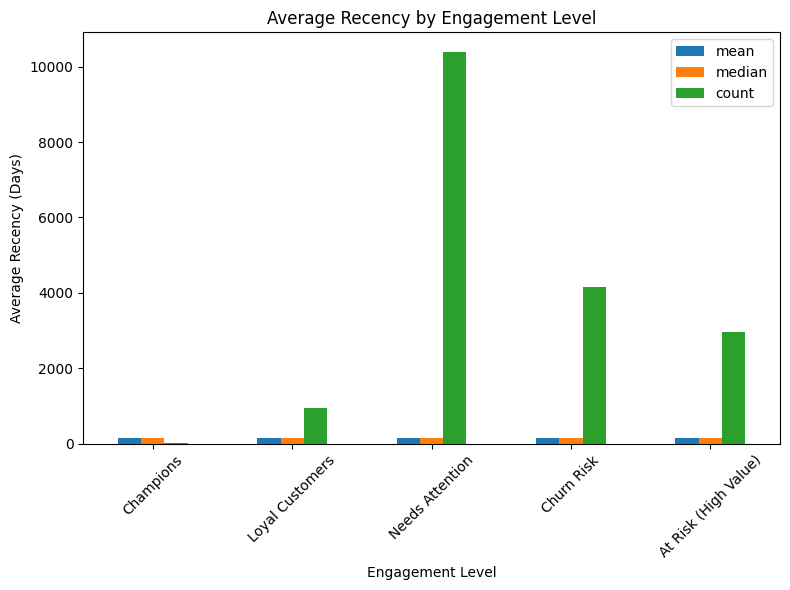

In [199]:
plt.figure()
recency_by_segment.plot(kind='bar')
plt.title('Average Recency by Engagement Level')
plt.xlabel('Engagement Level')
plt.ylabel('Average Recency (Days)')
plt.xticks(rotation=45)
plt.tight_layout()

# save visual
plt.savefig(
    'C:/Users/WISDOM PC/Downloads/avg_recency_by_engage_level.png',
    dpi=300,
    bbox_inches='tight'
)

plt.show()

### This engagement level show a clean monotonic trend (insight):
- Champions → Loyal → Needs Attention → Churn Risk → At Risk (High Value)
-  (low recency) ---------------------------------------------- (high recency)


- Engagement level exhibit a clear increase in recency from Champions to At-Risk customers, validating the effectiveness of the RFM-based churn classification.

In [200]:
df.groupby(['age_group', 'customer_segment','engagement_level']).agg({'total_sales': 'sum'})

total_sales
age_group customer_segment engagement_level                 
40-49     New              At Risk (High Value)      1469836
                           Champions                    1317
                           Churn Risk                 222105
                           Loyal Customers             50588
                           Needs Attention           1440873
          Regular          At Risk (High Value)       783610
                           Loyal Customers             72327
                           Needs Attention           1697240
          VIP              At Risk (High Value)       916919
                           Loyal Customers            967496
                           Needs Attention           1042408
above 50  New              At Risk (High Value)      3438609
                           Champions                   32739
                           Churn Risk                 496910
                           Loyal Customers            123385
                           Needs Attention           3810435
          Regular          At Risk (High Value)      1241270
                           Champions                    3644
                           Loyal Customers            190756
                           Needs Attention           3515144
          VIP              At Risk (High Value)      2577726
                           Champions                   75309
                           Loyal Customers           2443694
                           Needs Attention           2736918

In [201]:
High_Risk_cust = ['At Risk (High Value)', 'Churn Risk']
Loyal_cust = ['Champions', 'Loyal Customers']
high_risk_sales = df.query("engagement_level.isin(@High_Risk_cust)")[['total_sales']].sum()
loyal_sales = df.query("engagement_level.isin(@Loyal_cust)")[['total_sales']].sum()

print(f"High Risk Customers: {high_risk_sales['total_sales']:.2f}")
print(f"Loyal Customers: {loyal_sales['total_sales']:.2f}")


High Risk Customers: 11146985.00
Loyal Customers: 3961255.00


### Sales Imbalance: High-Risk vs Loyal Segments (insight):
- High-risk segments (At Risk + Churn Risk) generate almost 3x more sales than loyal segments (Champions + Loyal Customers). 

***Note:*** Focus on retaining these high-value at-risk customers to sustain revenue.

### Customer Lifecycle & Value (insight):

- Older customers (40+) are more loyal when VIP.
- High-value customers are at risk across the board - need retention focus.
- Lots of new customers need engagement boost.

## Churn & Retention General Insight

Customer engagement shows a clear and consistent relationship with churn risk. Segments with higher average recency values exhibit lower engagement and a higher likelihood of churn.

Champions and Loyal Customers demonstrate the lowest recency, indicating strong ongoing engagement and minimal churn risk. In contrast, Churn Risk and At Risk (High Value) customers display significantly higher recency, confirming early warning signals of disengagement.

This pattern validates the use of recency-based behavioral signals as an effective proxy for churn detection in the absence of an explicit churn label.


-----------------------------------------------------------------------------------------------------------------------------------

# Customer Lifetime Value (CLV) Analysis

Customer Lifetime Value (CLV) was estimated using historical behavior as the product of average monthly spend and customer lifespan. This metric provides an approximation of each customer’s long-term revenue contribution.


In [202]:
df.head()

,customer_key,customer_number,customer_name,age,age_group,customer_segment,last_order_date,recency,total_orders,total_sales,total_quantity,lifespan,avg_order_value,avg_monthly_spend,R_score,F_score,M_score,engagement_level
0,1,AW00011000,Jon Yang,55,above 50,VIP,2013-05-03,152,3,8249,8,28,2749,294,2,3,5,At Risk (High Value)
1,2,AW00011001,Eugene Huang,50,above 50,VIP,2013-12-10,145,3,6384,11,35,2128,182,5,3,5,Loyal Customers
2,3,AW00011002,Ruben Torres,55,above 50,VIP,2013-02-23,155,3,8114,4,25,2704,324,1,3,5,At Risk (High Value)
3,4,AW00011003,Christy Zhu,53,above 50,VIP,2013-05-10,152,3,8139,9,29,2713,280,2,3,5,At Risk (High Value)
4,5,AW00011004,Elizabeth Johnson,47,40-49,VIP,2013-05-01,152,3,8196,6,28,2732,292,2,3,5,At Risk (High Value)


In [203]:
df[df['engagement_level'].isin(['At Risk (High Value)', 'Churn Risk'])]['total_sales'].sum()

np.int64(11146985)

In [204]:
df[df['engagement_level'].isin(['Champions', 'Loyal Customers'])]['total_sales'].sum()

np.int64(3961255)

In [205]:
df['customer_lifetime_value'] = df['lifespan'] * df['avg_monthly_spend']

In [206]:
df.head(2)

,customer_key,customer_number,customer_name,age,age_group,customer_segment,last_order_date,recency,total_orders,total_sales,total_quantity,lifespan,avg_order_value,avg_monthly_spend,R_score,F_score,M_score,engagement_level,customer_lifetime_value
0,1,AW00011000,Jon Yang,55,above 50,VIP,2013-05-03,152,3,8249,8,28,2749,294,2,3,5,At Risk (High Value),8232
1,2,AW00011001,Eugene Huang,50,above 50,VIP,2013-12-10,145,3,6384,11,35,2128,182,5,3,5,Loyal Customers,6370


In [207]:
df[['customer_key', 'avg_monthly_spend', 'lifespan', 'customer_lifetime_value']].head()

,customer_key,avg_monthly_spend,lifespan,customer_lifetime_value
0,1,294,28,8232
1,2,182,35,6370
2,3,324,25,8100
3,4,280,29,8120
4,5,292,28,8176


In [208]:
clv_by_segment = (
    df.groupby('engagement_level')['customer_lifetime_value']
      .agg(mean='mean', median='median', count='count')
      .sort_values('mean', ascending=False)
)

clv_by_segment

,mean,median,count
engagement_level,,,
Champions,6271.944444,5465.0,18
Loyal Customers,4022.430366,5185.0,955
At Risk (High Value),2545.242886,2510.0,2952
Needs Attention,1063.623629,0.0,10394
Churn Risk,5.210185,0.0,4163


<Figure size 800x600 with 0 Axes>

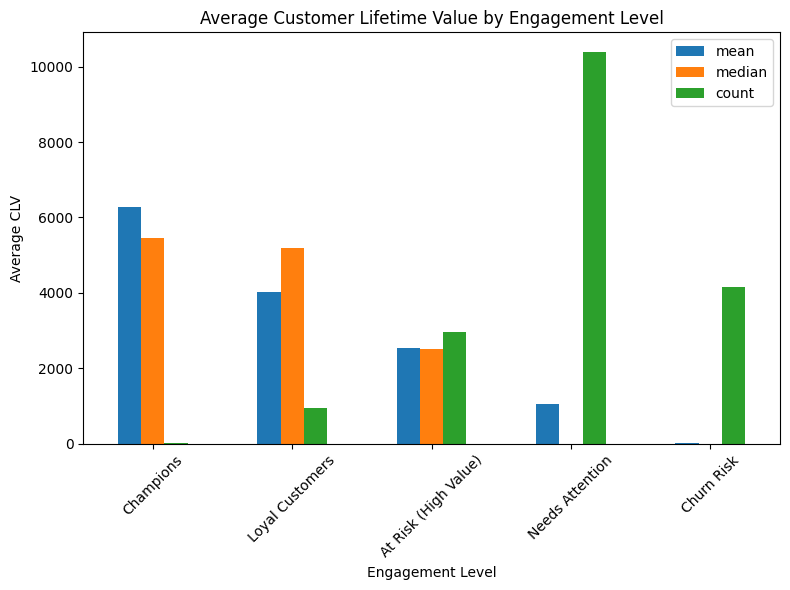

In [209]:
plt.figure()
clv_by_segment.plot(kind='bar')
plt.title('Average Customer Lifetime Value by Engagement Level')
plt.xlabel('Engagement Level')
plt.ylabel('Average CLV')
plt.xticks(rotation=45)
plt.tight_layout()

# save visual
plt.savefig(
    'C:/Users/WISDOM PC/Downloads/avg_clv_by_engage_level.png',
    dpi=300,
    bbox_inches='tight'
)

plt.show()

### Customer Lifetime Value (CLV) Analysis General Insight

Customer Lifetime Value varies significantly across engagement segments, highlighting substantial differences in long-term revenue contribution.

Champions and Loyal Customers generate the highest average CLV, confirming that frequent and recent engagement translates directly into long-term value. Although At Risk (High Value) customers show declining engagement, they still maintain relatively high lifetime value, making them critical targets for retention.

Conversely, Churn Risk customers contribute minimal lifetime value, indicating limited return on further retention investment.



----------------------------------------------------------------------------------------------------------------------------------

# Revenue & Customer Value Prioritization

Revenue and customer value prioritization was performed by combining engagement-based segmentation with customer lifetime value and total revenue contribution. This analysis identifies which customer segments should receive the highest strategic focus based on both current revenue impact and expected long-term value.

By evaluating average CLV, total revenue, and customer volume together, the business can distinguish between high-value segments that require protection, segments with growth potential, and low-value segments that should be deprioritized.


In [210]:
revenue_value_prioritization = (
    df.groupby('engagement_level')
      .agg(
          avg_clv=('customer_lifetime_value', 'mean'),
          total_revenue=('total_sales', 'sum'),
          customer_count=('customer_key', 'count')
      )
      .sort_values('avg_clv', ascending=False)
)

revenue_value_prioritization


,avg_clv,total_revenue,customer_count
engagement_level,,,
Champions,6271.944444,113009,18
Loyal Customers,4022.430366,3848246,955
At Risk (High Value),2545.242886,10427970,2952
Needs Attention,1063.623629,14243018,10394
Churn Risk,5.210185,719015,4163


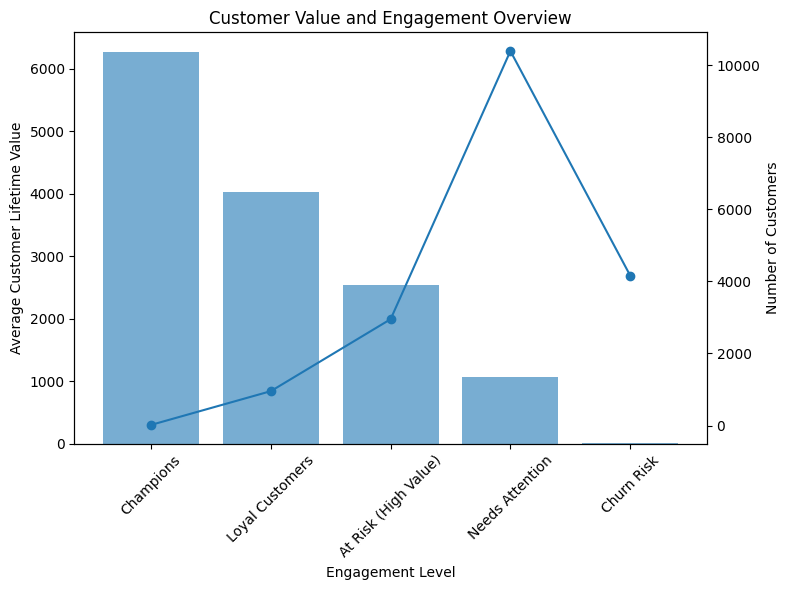

In [211]:
import matplotlib.pyplot as plt

summary = (
    df.groupby('engagement_level')
      .agg(
          avg_clv=('customer_lifetime_value', 'mean'),
          customer_count=('customer_key', 'count')
      )
      .sort_values('avg_clv', ascending=False)
)

fig, ax1 = plt.subplots()

# Bar chart: Average CLV (with transparency)
ax1.bar(
    summary.index,
    summary['avg_clv'],
    alpha=0.6          # transparency
)
ax1.set_xlabel('Engagement Level')
ax1.set_ylabel('Average Customer Lifetime Value')
ax1.tick_params(axis='x', rotation=45)

# Line chart: Customer Count (different color)
ax2 = ax1.twinx()
ax2.plot(
    summary.index,
    summary['customer_count'],
    marker='o',
    linestyle='-'
)
ax2.set_ylabel('Number of Customers')

plt.title('Customer Value and Engagement Overview')
plt.tight_layout()

# save visual
plt.savefig(
    'C:/Users/WISDOM PC/Downloads/cust_value_engage_overview.png',
    dpi=300,
    bbox_inches='tight'
)

plt.show()

### Revenue & Customer Value Prioritization General Insight:

In particular, *At Risk (High Value)* customers represent a critical retention opportunity, as they maintain relatively high lifetime value despite elevated churn signals. Conversely, *Churn Risk* customers exhibit minimal lifetime value and should be deprioritized in retention spending.


-----------------------------------------------------------------------------------------------------------------------------------

# Customer Value & Engagement Action Matrix


The Customer Value & Engagement Action Matrix translates analytical findings into actionable business strategy. By aligning customer segments with both engagement behavior and lifetime value, the matrix enables efficient allocation of retention and marketing resources.

High-value segments require proactive retention and loyalty initiatives, while mid-tier segments benefit from scalable engagement strategies. Low-value, disengaged customers should receive minimal investment, ensuring focus remains on segments with the greatest revenue impact.

In [212]:
final_table = pd.DataFrame({
    'Engagement Level': [
        'Champions',
        'Loyal Customers',
        'At Risk (High Value)',
        'Needs Attention',
        'Churn Risk'
    ],
    'Avg CLV': [
        6271.94,
        4022.43,
        2545.24,
        1063.62,
        5.21
    ],
    'Priority': [
        'Critical',
        'High',
        'Critical',
        'Medium',
        'Low'
    ],
    'Strategy': [
        'Retain & reward',
        'Upsell & cross-sell',
        'Win-back campaigns',
        'Engagement nudges',
        'Deprioritize'
    ]
})

final_table


,Engagement Level,Avg CLV,Priority,Strategy
0,Champions,6271.94,Critical,Retain & reward
1,Loyal Customers,4022.43,High,Upsell & cross-sell
2,At Risk (High Value),2545.24,Critical,Win-back campaigns
3,Needs Attention,1063.62,Medium,Engagement nudges
4,Churn Risk,5.21,Low,Deprioritize


## Customer Value & Engagement Action Matrix (Business Strategy)

| Engagement Level     | Avg CLV | Priority     | Strategy                                    |
| -------------------- | ------: | ------------ | ------------------------------------------- |
| Champions            |  ~6,272 | **Critical** | Retain & reward (loyalty perks, exclusives) |
| Loyal Customers      |  ~4,022 | **High**     | Upsell & cross-sell to move to Champions    |
| At Risk (High Value) |  ~2,545 | **Critical** | Win-back campaigns, personalized offers     |
| Needs Attention      |  ~1,064 | **Medium**   | Engagement nudges, reminders, light promos  |
| Churn Risk           |      ~5 | **Low**      | Deprioritize or low-cost reactivation       |


### Customer Lifetime Value by Engagement Level General Insight
  Customer lifetime value declines sharply from Champions to Churn Risk segments confirming that engagement level is a strong indicator of long-term customer value and validating the RFM-based segmentation approach.


-----------------------------------------------------------------------------------------------------------------------------------

# Visualization
- Average CLV by Engagement Level
- Customer Distribution by Segment
- Revenue at Risk

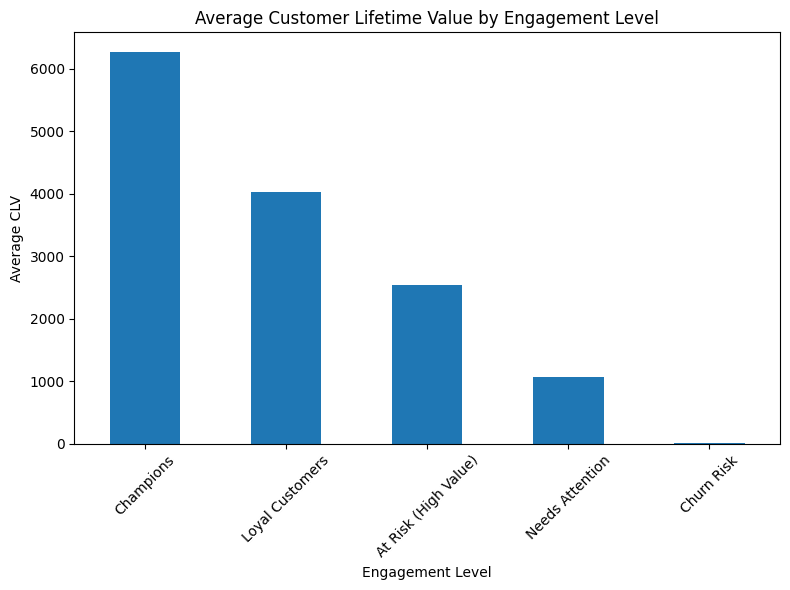

In [213]:
# Average CLV by Engagement Level


clv_by_segment = (
    df.groupby('engagement_level')['customer_lifetime_value']
      .mean()
      .sort_values(ascending=False)
)

plt.figure()
clv_by_segment.plot(kind='bar')
plt.title('Average Customer Lifetime Value by Engagement Level')
plt.xlabel('Engagement Level')
plt.ylabel('Average CLV')
plt.xticks(rotation=45)
plt.tight_layout()

# save visual
plt.savefig(
    'C:/Users/WISDOM PC/Downloads/avg_cust_lifetime_value_by_engage_level.png',
    dpi=300,
    bbox_inches='tight'
)

plt.show()

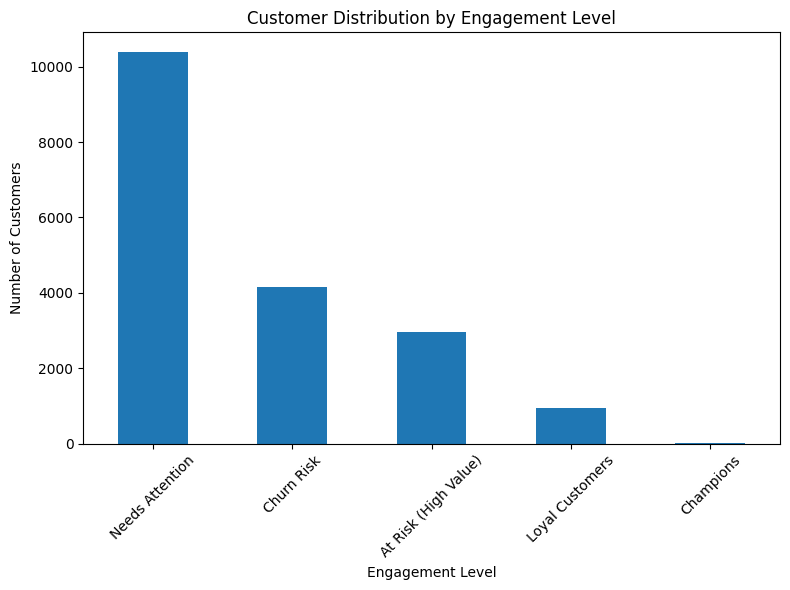

In [214]:
# Customer Distribution by Engagement Level

segment_counts = df['engagement_level'].value_counts()

plt.figure()
segment_counts.plot(kind='bar')
plt.title('Customer Distribution by Engagement Level')
plt.xlabel('Engagement Level')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()

# save visual
plt.savefig(
    'C:/Users/WISDOM PC/Downloads/cust_dist_by_engage_level.png',
    dpi=300,
    bbox_inches='tight'
)

plt.show()

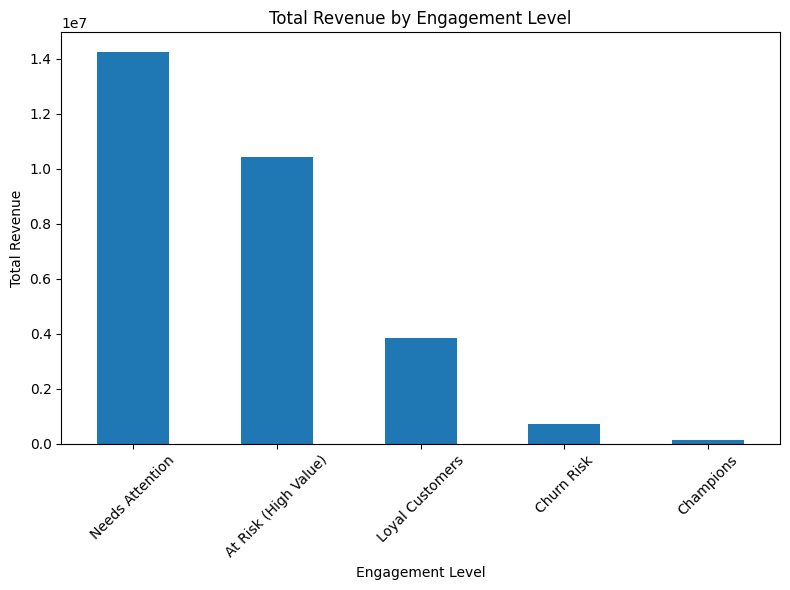

In [215]:
# Revenue at Risk

revenue_by_segment = (
    df.groupby('engagement_level')['total_sales']
      .sum()
      .sort_values(ascending=False)
)

plt.figure()
revenue_by_segment.plot(kind='bar')
plt.title('Total Revenue by Engagement Level')
plt.xlabel('Engagement Level')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()

# save visual
plt.savefig(
    'C:/Users/WISDOM PC/Downloads/total_revenue_by_engage_level.png',
    dpi=300,
    bbox_inches='tight'
)

plt.show()

-----------------------------------------------------------------------------------------------------------------------------------

# General Insight

- Customer engagement and value are strongly correlated. Highly engaged customers consistently generate higher lifetime value, validating the use of RFM-based segmentation for understanding customer behavior.

- Champions and Loyal Customers deliver the highest long-term value but represent a relatively small portion of the overall customer base, indicating concentration of value among a limited group.

- At Risk (High Value) customers pose the greatest threat to future revenue. Although their engagement has declined, they retain significant lifetime value, making them the most critical segment for retention efforts.

- The majority of customers fall into the Needs Attention segment, suggesting a large opportunity for scalable engagement strategies that can improve retention without heavy resource investment.

- Churn Risk customers exhibit both low engagement and negligible lifetime value, indicating limited return on aggressive retention spending.


# Recommendations

- Prioritize retention efforts for Champions by offering loyalty incentives, exclusive benefits, and frictionless experiences to protect high-value relationships.

- Implement targeted upsell and cross-sell initiatives for Loyal Customers to increase their lifetime value and transition them into the Champions segment.

- Launch personalized win-back campaigns for At Risk (High Value) customers, focusing on tailored offers and timely re-engagement to prevent revenue loss.

- Deploy automated and scalable engagement campaigns for Needs Attention customers, such as reminders, personalized content, or light promotions, to improve overall engagement efficiently.

- Deprioritize Churn Risk customers in retention spending and reallocate resources toward acquisition or higher-impact retention opportunities.


-----------------------------------------------------------------------------------------------------------------------------------